### Load the dataset

In [1]:
!pip install -q -U einops datasets matplotlib tqdm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 68.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.4 MB/s eta 0:00:00


In [2]:
from torch import nn
import torch
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.transforms import ToTensor
import numpy as np
from torch.optim import Adam

In [3]:
class DownBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        kernel_size = 3
        stride = 1
        padding = 1

        super().__init__()
        layers = [
            nn.Conv2d(in_ch, out_ch, kernel_size, stride, padding),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, kernel_size, stride, padding),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.MaxPool2d(2)
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [4]:
class UpBlock(nn.Module):
    def __init__(self, in_chs, out_chs):
        # Convolution variables
        kernel_size = 3
        stride = 1
        padding = 1

        # Transpose variables
        strideT = 2
        out_paddingT = 1

        super().__init__()
        # 2 * in_chs for concatenated skip connection
        layers = [
            nn.ConvTranspose2d(2 * in_chs, out_chs, kernel_size, strideT, padding, out_paddingT),
            nn.BatchNorm2d(out_chs),
            nn.ReLU(),
            nn.Conv2d(out_chs, out_chs, kernel_size, stride, padding),
            nn.BatchNorm2d(out_chs),
            nn.ReLU()
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip):
        x = torch.cat((x, skip), 1)
        x = self.model(x)
        return x

In [5]:
class EmbedBlock(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super().__init__()
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.ReLU(),
            nn.Linear(emb_dim, emb_dim),
            nn.Unflatten(1, (emb_dim, 1, 1))
        ]
        self.model = nn.Sequential(*layers)
    def forward(self, input):
        input = input.view(-1, self.input_dim)
        return self.model(input)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()


True

In [7]:
import torch
import torchvision
from torchvision.transforms import Resize, Compose, ToTensor, Lambda, ToPILImage

import math
from inspect import isfunction
from functools import partial
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange, reduce
from einops.layers.torch import Rearrange

import torch
from torch import nn, einsum
import torch.nn.functional as F

IMG_SIZE = 28
IMG_CH = 1
BATCH_SIZE = 128

def load_dataset_with_transform():
    data_transforms = Compose([
        ToTensor(),
    ])

    dataset = torchvision.datasets.MNIST('./data/', transform=data_transforms, download=True)

    data_loader = torch.utils.data.DataLoader(dataset,
                                            batch_size=BATCH_SIZE,
                                            shuffle=True,
                                            num_workers=0)
    return data_loader

data = load_dataset_with_transform()

100%|██████████| 9912422/9912422 [00:00<00:00, 235837036.95it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 39978776.84it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 78234950.58it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 19050528.77it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [23]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        img_chs = IMG_CH
        down_chs = (16, 32, 64)
        up_chs = down_chs[::-1]  # Reverse of the down channels
        latent_image_size = IMG_SIZE // 4 # 2 ** (len(down_chs) - 1)
        t_dim = 1 # New

        # Inital convolution
        self.down0 = nn.Sequential(
            nn.Conv2d(img_chs, down_chs[0], 3, padding=1),
            nn.BatchNorm2d(down_chs[0]),
            nn.ReLU()
        )

        # Downsample
        self.down1 = DownBlock(down_chs[0], down_chs[1])
        self.down2 = DownBlock(down_chs[1], down_chs[2])
        self.to_vec = nn.Sequential(nn.Flatten(), nn.ReLU())

        # Embeddings
        self.dense_emb = nn.Sequential(
            nn.Linear(down_chs[2]*latent_image_size**2, down_chs[1]),
            nn.ReLU(),
            nn.Linear(down_chs[1], down_chs[1]),
            nn.ReLU(),
            nn.Linear(down_chs[1], down_chs[2]*latent_image_size**2),
            nn.ReLU()
        )

        self.temb_1 = EmbedBlock(t_dim, up_chs[0])  # New
        self.temb_2 = EmbedBlock(t_dim, up_chs[1])  # New

        # Upsample
        self.up0 = nn.Sequential(
            nn.Unflatten(1, (up_chs[0], latent_image_size, latent_image_size)),
            nn.Conv2d(up_chs[0], up_chs[0], 3, padding=1),
            nn.BatchNorm2d(up_chs[0]),
            nn.ReLU(),
        )
        self.up1 = UpBlock(up_chs[0], up_chs[1])
        self.up2 = UpBlock(up_chs[1], up_chs[2])

        # Match output channels
        self.out = nn.Sequential(
            nn.Conv2d(up_chs[-1], up_chs[-1], 3, 1, 1),
            nn.BatchNorm2d(up_chs[-1]),
            nn.ReLU(),
            nn.Conv2d(up_chs[-1], img_chs, 3, 1, 1)
        )

    def forward(self, x, t):
        down0 = self.down0(x)
        down1 = self.down1(down0)
        down2 = self.down2(down1)
        latent_vec = self.to_vec(down2)

        # New
        t = t.float() / T  # Convert from [0, T] to [0, 1]
        latent_vec = self.dense_emb(latent_vec)
        temb_1 = self.temb_1(t)
        temb_2 = self.temb_2(t)

        up0 = self.up0(latent_vec)
        up1 = self.up1(up0+temb_1, down2)
        up2 = self.up2(up1+temb_2, down1)
        return self.out(up2)

model = UNet().to(device)
print("Num params: ", sum(p.numel() for p in model.parameters()))


Num params:  377665


### Loss function for noise
Inorder to predict noise, we can MSE mechanism to find the loss between original image and when noise is added.

In the example below, an image is taken and noise is added to it at various timesteps.

The loss function calcualtes the image data loss with the original and its increase as in the curve

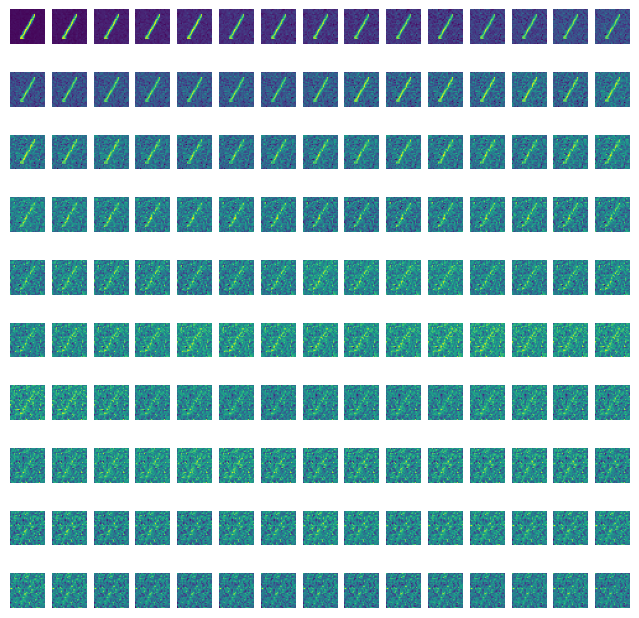

In [14]:
# image at certain step directly

nrows = 10
ncols = 15

T = nrows * ncols
start = 0.0001
end = 0.02
B = torch.linspace(start, end, T).to(device)

a = 1. - B
beta = B
iters = len(beta)
alpha = a
alpha_cumu_prod = torch.cumprod(alpha, dim=0)
sqrt_a_bar = torch.sqrt(alpha_cumu_prod).to(device)  # Mean Coefficient
sqrt_one_minus_a_bar = torch.sqrt(1 - alpha_cumu_prod).to(device) # St. Dev. Coefficient

def getImageAtIter(x_0, t):
    """
    Samples a new image from q
    Returns the noise applied to an image at timestep t
    x_0: the original image
    t: timestep
    """
    t = t.int()
    noise = torch.randn_like(x_0)
    sqrt_a_bar_t = sqrt_a_bar[t, None, None, None]
    sqrt_one_minus_a_bar_t = sqrt_one_minus_a_bar[t, None, None, None]

    x_t = sqrt_a_bar_t * x_0 + sqrt_one_minus_a_bar_t * noise
    return x_t, noise

def loss_fun(a,b):
    return torch.nn.MSELoss()(a,b)

plt.figure(figsize=(8, 8))
x_0 = next(iter(data))[0][0].to(device)  # Initial image
x_t = x_0  # Set up recursion
xs = []  # Store x_t for each T to see change

for t in range(T):
    noise = torch.randn_like(x_t)
    x_t = torch.sqrt(1 - B[t]) * x_t + torch.sqrt(B[t]) * noise
    img = torch.squeeze(x_t).cpu()
    xs.append(img)
    ax = plt.subplot(nrows, ncols, t + 1)
    ax.axis("off")
    plt.imshow(img)
plt.savefig("forward_diffusion.png", bbox_inches="tight")

The loss function can be used along with adam optimizer ar lr=0.0001 to learn about the loss.

In [20]:
def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: torch.minimum(torch.tensor([1]), t)),
        transforms.Lambda(lambda t: torch.maximum(torch.tensor([0]), t)),
        transforms.ToPILImage(),
    ])
    plt.imshow(reverse_transforms(image[0].detach().cpu()))
@torch.no_grad()

def q(x_0, t):
    """
    Samples a new image from q
    Returns the noise applied to an image at timestep t
    x_0: the original image
    t: timestep
    """
    t = t.int()
    noise = torch.randn_like(x_0)
    sqrt_a_bar_t = sqrt_a_bar[t, None, None, None]
    sqrt_one_minus_a_bar_t = sqrt_one_minus_a_bar[t, None, None, None]

    x_t = sqrt_a_bar_t * x_0 + sqrt_one_minus_a_bar_t * noise
    return x_t, noise

def get_loss(model, x_0, t):
    x_noisy, noise = q(x_0, t)
    noise_pred = model(x_noisy, t)
    return F.mse_loss(noise, noise_pred)

def sample_images(ncols, figsize=(8,8)):
    plt.figure(figsize=figsize)
    plt.axis("off")
    hidden_rows = T / ncols

    # Noise to generate images from
    x_t = torch.randn((1, 1, 28, 28), device=device)

    # Go from T to 0 removing and adding noise until t = 0
    plot_number = 1
    for i in range(0, T)[::-1]:
        t = torch.full((1,), i, device=device)
        e_t = model(x_t, t)  # Predicted noise
        x_t = reverse_q(x_t, t, e_t)
        if i % hidden_rows == 0:
            ax = plt.subplot(1, ncols+1, plot_number)
            ax.axis('off')
            show_tensor_image(x_t.detach().cpu())
            plot_number += 1
    plt.show()

In [11]:
sqrt_a_inv = torch.sqrt(1 / alpha)
pred_noise_coeff = (1 - alpha) / torch.sqrt(1 - alpha_cumu_prod)

@torch.no_grad()
def reverse_q(x_t, t, e_t):
    t = torch.squeeze(t[0].int())  # All t values should be the same
    pred_noise_coeff_t = pred_noise_coeff[t]
    sqrt_a_inv_t = sqrt_a_inv[t]
    u_t = sqrt_a_inv_t * (x_t - pred_noise_coeff_t * e_t)
    if t == 0:
        return u_t  # Reverse diffusion complete!
    else:
        B_t = beta[t-1]
        new_noise = torch.randn_like(x_t)
        return u_t + torch.sqrt(B_t) * new_noise

Epoch 0 | Step 000 | Loss: 0.06650007516145706 


<ipython-input-20-7b27ca4abaae>:46: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1, ncols+1, plot_number)


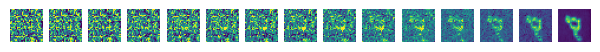

Epoch 0 | Step 100 | Loss: 0.0691646859049797 


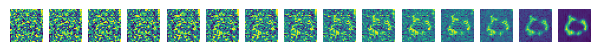

Epoch 0 | Step 200 | Loss: 0.07129724323749542 


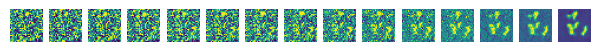

Epoch 0 | Step 300 | Loss: 0.07898173481225967 


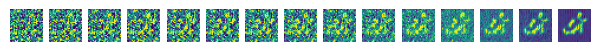

Epoch 0 | Step 400 | Loss: 0.07219062000513077 


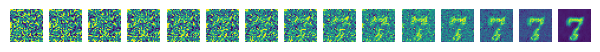

Epoch 1 | Step 000 | Loss: 0.0712398961186409 


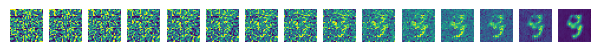

Epoch 1 | Step 100 | Loss: 0.07184790074825287 


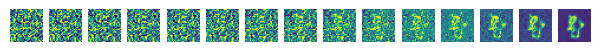

Epoch 1 | Step 200 | Loss: 0.061885684728622437 


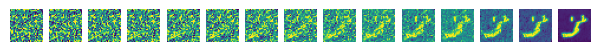

Epoch 1 | Step 300 | Loss: 0.07454601675271988 


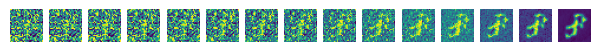

Epoch 1 | Step 400 | Loss: 0.0685499832034111 


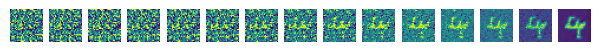

Epoch 2 | Step 000 | Loss: 0.06548935920000076 


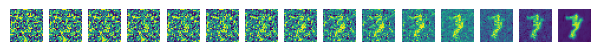

Epoch 2 | Step 100 | Loss: 0.06708753108978271 


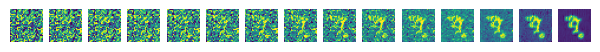

Epoch 2 | Step 200 | Loss: 0.07547493278980255 


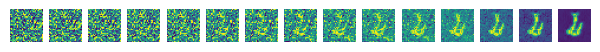

Epoch 2 | Step 300 | Loss: 0.07165069878101349 


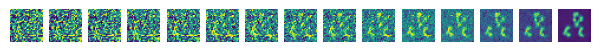

Epoch 2 | Step 400 | Loss: 0.06489778310060501 


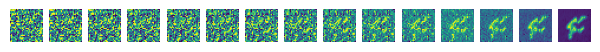

Epoch 3 | Step 000 | Loss: 0.06935902684926987 


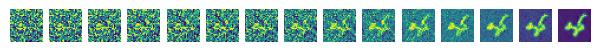

Epoch 3 | Step 100 | Loss: 0.06361430138349533 


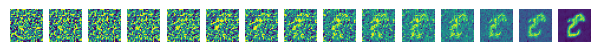

Epoch 3 | Step 200 | Loss: 0.06623928993940353 


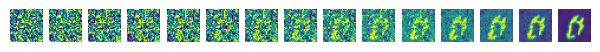

Epoch 3 | Step 300 | Loss: 0.06295070797204971 


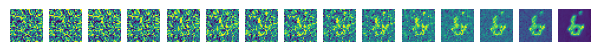

Epoch 3 | Step 400 | Loss: 0.07712922990322113 


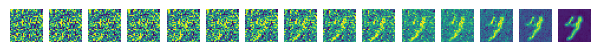

Epoch 4 | Step 000 | Loss: 0.06910397112369537 


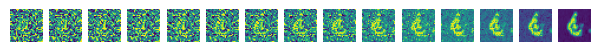

Epoch 4 | Step 100 | Loss: 0.07735592871904373 


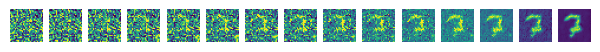

Epoch 4 | Step 200 | Loss: 0.06401355564594269 


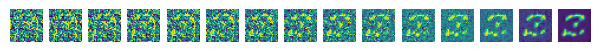

Epoch 4 | Step 300 | Loss: 0.06730426102876663 


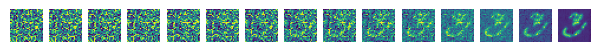

Epoch 4 | Step 400 | Loss: 0.06859169900417328 


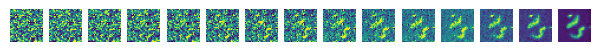

Epoch 5 | Step 000 | Loss: 0.06407146155834198 


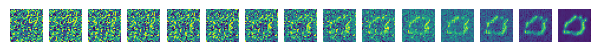

Epoch 5 | Step 100 | Loss: 0.06376604735851288 


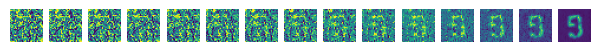

Epoch 5 | Step 200 | Loss: 0.06789971888065338 


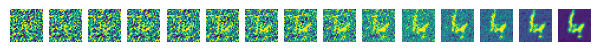

Epoch 5 | Step 300 | Loss: 0.06311733275651932 


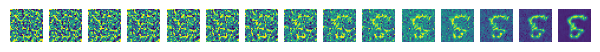

Epoch 5 | Step 400 | Loss: 0.06911146640777588 


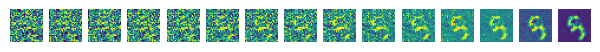

Epoch 6 | Step 000 | Loss: 0.07102248817682266 


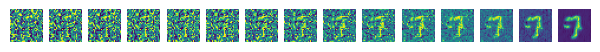

Epoch 6 | Step 100 | Loss: 0.0606212355196476 


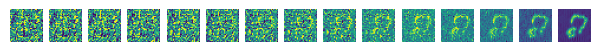

Epoch 6 | Step 200 | Loss: 0.0681753158569336 


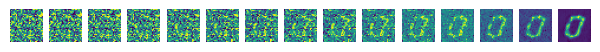

Epoch 6 | Step 300 | Loss: 0.07476839423179626 


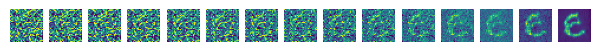

Epoch 6 | Step 400 | Loss: 0.07084673643112183 


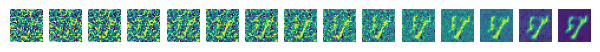

Epoch 7 | Step 000 | Loss: 0.06621624529361725 


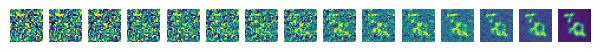

Epoch 7 | Step 100 | Loss: 0.06611461937427521 


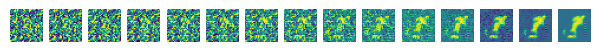

Epoch 7 | Step 200 | Loss: 0.06292377412319183 


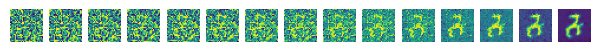

Epoch 7 | Step 300 | Loss: 0.06327129900455475 


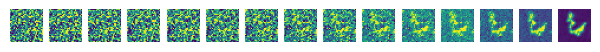

Epoch 7 | Step 400 | Loss: 0.06307891011238098 


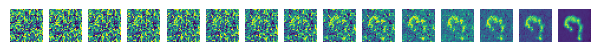

Epoch 8 | Step 000 | Loss: 0.06600722670555115 


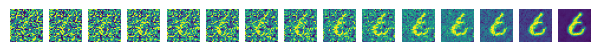

Epoch 8 | Step 100 | Loss: 0.06052951142191887 


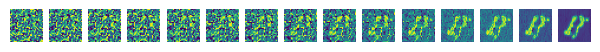

Epoch 8 | Step 200 | Loss: 0.06421133130788803 


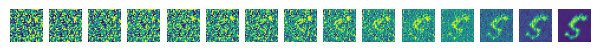

Epoch 8 | Step 300 | Loss: 0.06270256638526917 


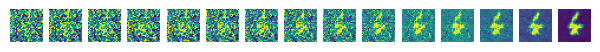

Epoch 8 | Step 400 | Loss: 0.06948470324277878 


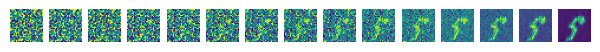

Epoch 9 | Step 000 | Loss: 0.06746245175600052 


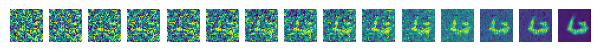

Epoch 9 | Step 100 | Loss: 0.0756068080663681 


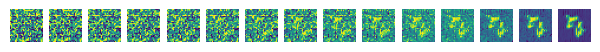

Epoch 9 | Step 200 | Loss: 0.06478960812091827 


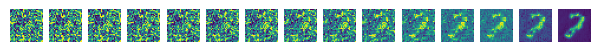

Epoch 9 | Step 300 | Loss: 0.07045955955982208 


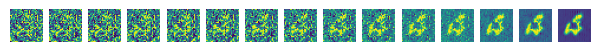

Epoch 9 | Step 400 | Loss: 0.06476981937885284 


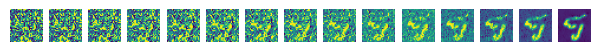

Final sample:


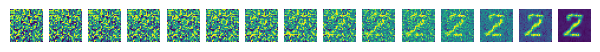

In [30]:
optimizer = Adam(model.parameters(), lr=0.0001)
epochs = 10
ncols = 15  # Should evenly divide T

model.train()
for epoch in range(epochs):
    for step, batch in enumerate(data):
        optimizer.zero_grad()

        t = torch.randint(0, T, (len(batch[0]),), device=device)
        x = batch[0].to(device)
        loss = get_loss(model, x, t)
        loss.backward()
        optimizer.step()

        if epoch % 1 == 0 and step % 100 == 0:
            print(f"Epoch {epoch} | Step {step:03d} | Loss: {loss.item()} ")
            sample_images(ncols)
print("Final sample:")
sample_images(ncols)

<ipython-input-20-7b27ca4abaae>:46: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1, ncols+1, plot_number)


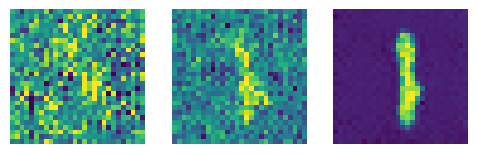

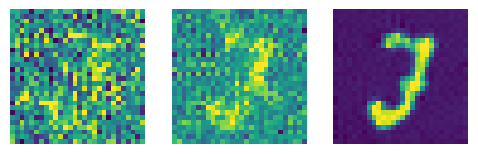

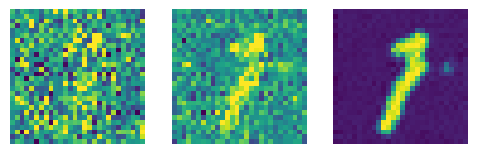

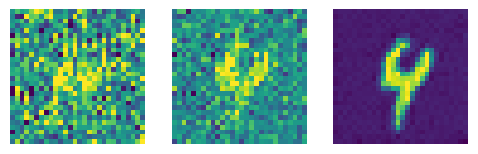

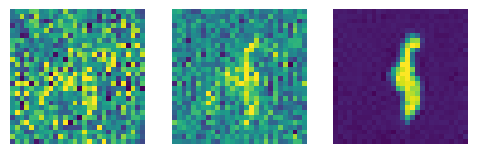

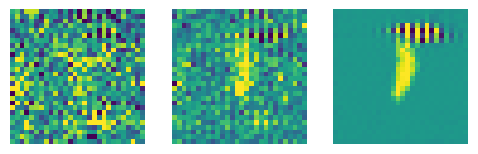

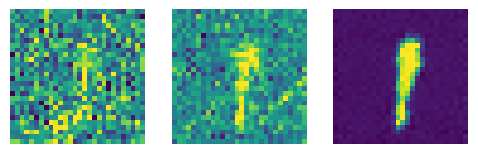

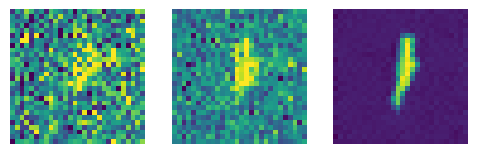

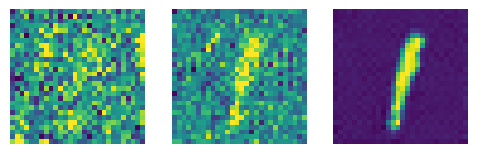

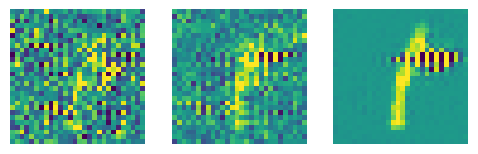

In [38]:
model.eval()
figsize=(8,8) # Change me
ncols = 3 # Should evenly divide T
for _ in range(10):
    sample_images(ncols, figsize=figsize)